<a href="https://colab.research.google.com/github/Khalidhussainn/Final_Year_Project/blob/main/ML/SLA/Suspicious_Login_Detection(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Suspicious Login Detection in Windows (Using Wazuh Archive Logs)
---
## Step by Step Guide for Beginners

### Step 0: Mount Google Drive (Colab Only)

### Step 1: Import Libraries

### Step 2: Load Data

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import joblib
import os
file_path = "/content/normal_behavior_9am_to_5pm.csv"
df = pd.read_csv(file_path)
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (7221, 9)


,@timestamp,data.win.system.eventID,agent.name,data.win.eventdata.authenticationPackageName,data.win.system.processID,data.win.system.systemTime,data.win.eventdata.logonType,data.win.eventdata.logonProcessName,data.win.eventdata.targetUserName
0,2025-04-20 16:00:58.597,4624,LAB3-09,Negotiate,1072,2025-04-20T11:02:14.2770369Z,5,Advapi,SYSTEM
1,2025-04-20 16:00:58.592,4624,LAB3-09,Negotiate,1072,2025-04-20T11:02:14.2759911Z,5,Advapi,SYSTEM
2,2025-04-20 16:00:53.790,4624,LAB3-10,Negotiate,1032,2025-04-20T11:02:09.4134324Z,5,Advapi,SYSTEM
3,2025-04-20 15:59:55.184,4625,LAB3-11,Negotiate,892,2025-04-20T11:01:10.0486195Z,2,User32,bsit22f.0013
4,2025-04-20 15:58:53.656,4625,LAB3-11,Negotiate,892,2025-04-20T11:00:08.4888022Z,2,User32,bsit22f.0013


### Step 3: Basic Data Exploration & Cleaning

In [16]:

print("Columns:", df.columns.tolist())
df.info()
print(df.isnull().sum())
duplicate_counts = df.duplicated().sum()
print("Total duplicate rows:", duplicate_counts)
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)


Columns: ['@timestamp', 'data.win.system.eventID', 'agent.name', 'data.win.eventdata.authenticationPackageName', 'data.win.system.processID', 'data.win.system.systemTime', 'data.win.eventdata.logonType', 'data.win.eventdata.logonProcessName', 'data.win.eventdata.targetUserName']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7221 entries, 0 to 7220
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   @timestamp                                    7221 non-null   object
 1   data.win.system.eventID                       7221 non-null   int64 
 2   agent.name                                    7221 non-null   object
 3   data.win.eventdata.authenticationPackageName  7221 non-null   object
 4   data.win.system.processID                     7221 non-null   int64 
 5   data.win.system.systemTime                    7221 non-null   object
 6   data.win.eventdat

### Step 4: Feature Selection

In [17]:

cols_to_keep = [
    "@timestamp", "data.win.system.eventID", "agent.name", "data.win.eventdata.logonType"
]
df = df[cols_to_keep]
print("Shape after column selection:", df.shape)
df.head()


Shape after column selection: (6828, 4)


,@timestamp,data.win.system.eventID,agent.name,data.win.eventdata.logonType
0,2025-04-20 16:00:58.597,4624,LAB3-09,5
1,2025-04-20 16:00:58.592,4624,LAB3-09,5
2,2025-04-20 16:00:53.790,4624,LAB3-10,5
3,2025-04-20 15:59:55.184,4625,LAB3-11,2
4,2025-04-20 15:58:53.656,4625,LAB3-11,2


### Step 5: Value Counts for Categorical Columns

In [18]:

for col in cols_to_keep[1:]:
    print(f"\nUnique value counts for {col}:\n", df[col].value_counts())



Unique value counts for data.win.system.eventID:
 data.win.system.eventID
4624    6203
4625     625
Name: count, dtype: int64

Unique value counts for agent.name:
 agent.name
CP-AKT-002912      1202
DESKTOP-5JEIKFF     861
LAB3-10             764
LAB3-09             692
CP-AKT-002931       690
LAB3-18             545
CP-AKT-002907       526
LAB3-11             504
CP-AKT-000210       503
CP-AKT-002911       232
CP-AKT000209        169
CP-AKT-002908       140
Name: count, dtype: int64

Unique value counts for data.win.eventdata.logonType:
 data.win.eventdata.logonType
5     5624
3      772
2      362
11      57
7       13
Name: count, dtype: int64


### Step 6: Data Visualization

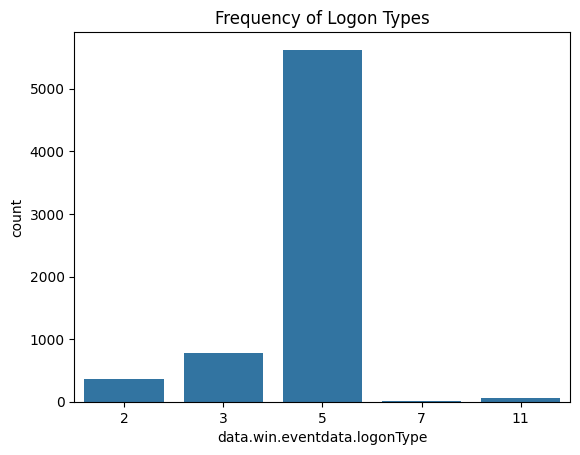

<ipython-input-6-1314829585>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_agents.values, y=top_agents.index, palette="magma")


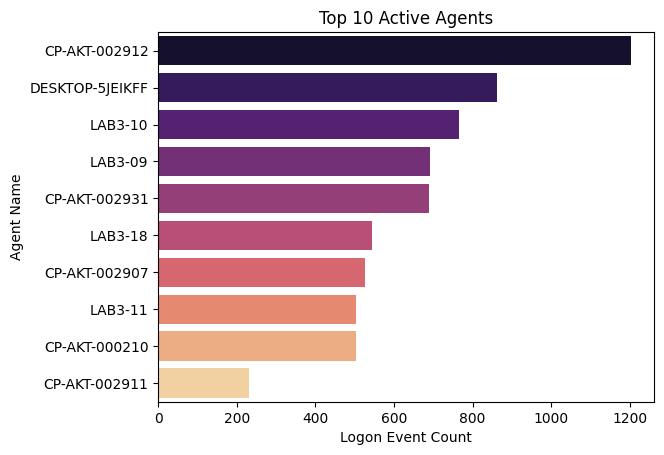

In [6]:


sns.countplot(x="data.win.eventdata.logonType", data=df)
plt.title("Frequency of Logon Types")
plt.show()

top_agents = df["agent.name"].value_counts().nlargest(10)
sns.barplot(x=top_agents.values, y=top_agents.index, palette="magma")
plt.title("Top 10 Active Agents")
plt.xlabel("Logon Event Count")
plt.ylabel("Agent Name")
plt.show()


### Step 7: Timestamp Processing & Feature Engineering

In [7]:

df['@timestamp'] = df['@timestamp'].str.replace(' @ ', ' ', regex=False)
df['@timestamp'] = pd.to_datetime(df['@timestamp'], errors='coerce')
df = df.dropna(subset=['@timestamp'])
df['year'] = df['@timestamp'].dt.year
df['month'] = df['@timestamp'].dt.month
df['day'] = df['@timestamp'].dt.day
df['hour'] = df['@timestamp'].dt.hour
df['minute'] = df['@timestamp'].dt.minute
df['second'] = df['@timestamp'].dt.second
df['day_of_week'] = df['@timestamp'].dt.dayofweek
df.head()


,@timestamp,data.win.system.eventID,agent.name,data.win.eventdata.logonType,year,month,day,hour,minute,second,day_of_week
0,2025-04-20 16:00:58.597,4624,LAB3-09,5,2025,4,20,16,0,58,6
1,2025-04-20 16:00:58.592,4624,LAB3-09,5,2025,4,20,16,0,58,6
2,2025-04-20 16:00:53.790,4624,LAB3-10,5,2025,4,20,16,0,53,6
3,2025-04-20 15:59:55.184,4625,LAB3-11,2,2025,4,20,15,59,55,6
4,2025-04-20 15:58:53.656,4625,LAB3-11,2,2025,4,20,15,58,53,6


### Step 8: Label Encoding

In [8]:

label_cols = ["agent.name", "data.win.eventdata.logonType", "data.win.system.eventID"]
label_encoders = {}
for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
df.head()


,@timestamp,data.win.system.eventID,agent.name,data.win.eventdata.logonType,year,month,day,hour,minute,second,day_of_week
0,2025-04-20 16:00:58.597,0,8,2,2025,4,20,16,0,58,6
1,2025-04-20 16:00:58.592,0,8,2,2025,4,20,16,0,58,6
2,2025-04-20 16:00:53.790,0,9,2,2025,4,20,16,0,53,6
3,2025-04-20 15:59:55.184,1,10,0,2025,4,20,15,59,55,6
4,2025-04-20 15:58:53.656,1,10,0,2025,4,20,15,58,53,6


### Step 9: Prepare Features

In [9]:

feature_columns = [
    "data.win.system.eventID", "agent.name", "data.win.eventdata.logonType",
    "year", "month", "day", "hour", "minute", "second", "day_of_week"
]
X = df[feature_columns]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [21]:

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(X_scaled)
df['Anomaly'] = iso_forest.predict(X_scaled)
df['Anomaly'] = df['Anomaly'].map({1: 0, -1: 1})
print(df['Anomaly'].value_counts())


Anomaly
0    6760
1      68
Name: count, dtype: int64


### Step 11: Anomaly Visualization

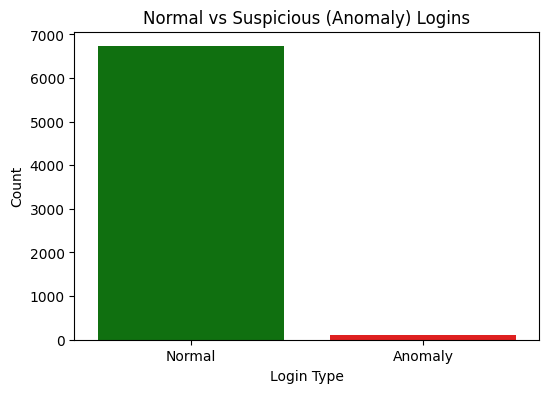

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(x="Anomaly", data=df, hue="Anomaly", palette={0: "green", 1: "red"}, legend=False)

plt.xticks([0, 1], ["Normal", "Anomaly"])
plt.title("Normal vs Suspicious (Anomaly) Logins")
plt.xlabel("Login Type")
plt.ylabel("Count")
plt.show()


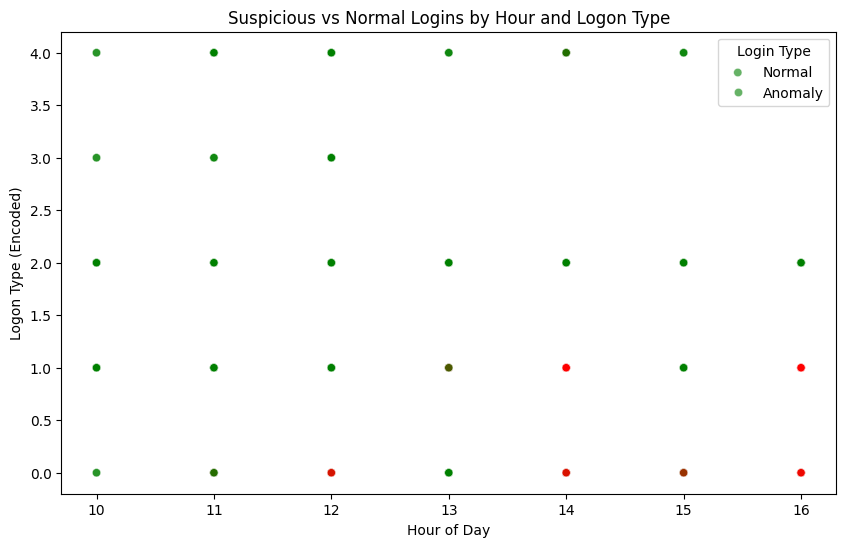

In [12]:
# Step 13: Visualization - Scatter Plot (Hour vs Logon Type)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=df['hour'],
    y=df['data.win.eventdata.logonType'],
    hue=df['Anomaly'],
    palette={0: "green", 1: "red"},
    alpha=0.6
)
plt.title("Suspicious vs Normal Logins by Hour and Logon Type")
plt.xlabel("Hour of Day")
plt.ylabel("Logon Type (Encoded)")
plt.legend(title="Login Type", labels=["Normal", "Anomaly"])
plt.show()


### Step 12: PCA Visualization

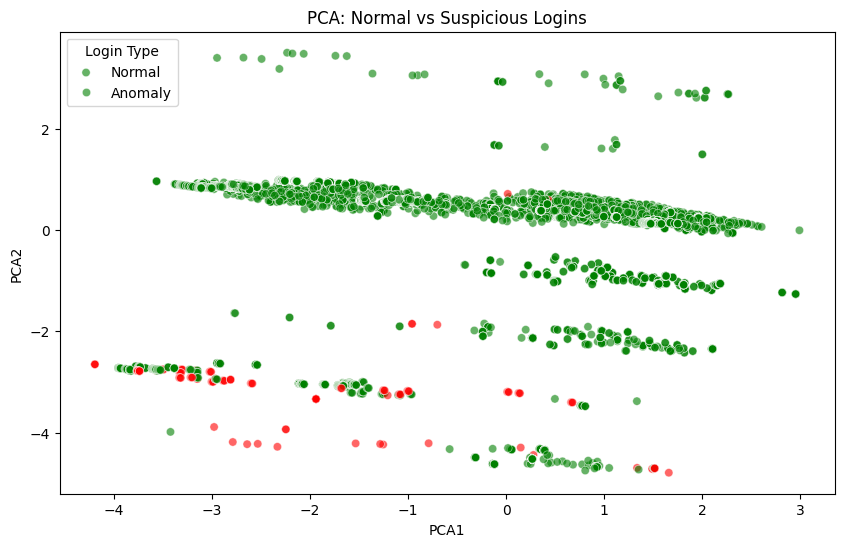

In [13]:
# Step 14: Visualization - PCA Plot (All Features in 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x="PCA1", y="PCA2", hue="Anomaly", data=df, palette={0: "green", 1: "red"}, alpha=0.6)
plt.title("PCA: Normal vs Suspicious Logins")
plt.legend(title="Login Type", labels=["Normal", "Anomaly"])
plt.show()

In [14]:
# Step 15: Save Model and Preprocessing for Later Use (Optional)
export_dir = '/content/drive/MyDrive/Colab Notebooks/SLA/Data_exports'
os.makedirs(export_dir, exist_ok=True)
joblib.dump(iso_forest, f'{export_dir}/iso_forest_model.pkl')
joblib.dump(scaler, f'{export_dir}/scaler.pkl')
for col, le in label_encoders.items():
    joblib.dump(le, f"{export_dir}/label_encoder_{col}.pkl")
joblib.dump(feature_columns, f"{export_dir}/feature_columns.pkl")
event_id_mapping = {
    "4624": "Successful Logon",
    "4625": "Failed Logon"
}
joblib.dump(event_id_mapping, f'{export_dir}/event_id_mapping.pkl')

print(f"All models/artifacts exported to: {export_dir}")

All models/artifacts exported to: /content/drive/MyDrive/Colab Notebooks/SLA/Data_exports
